# Sprawdzanie środowiska

In [1]:
from platform import python_version

print(python_version())

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

3.7.4
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9321901426129314970
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6661821563
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4292150967639531701
physical_device_desc: "device: 0, name: GeForce GTX 1070 Ti, pci bus id: 0000:1f:00.0, compute capability: 6.1"
]


# Przygotowanie odpowiednich danych

In [1]:
'''
Dla PoC wykonuje obliczenia dla:
 * '../data/DogsCats'
Folder docelowy:
 * '../data/Photos'
'''

dir_path = '../data/DogsCats'
A_folder = 'cats'
B_folder = 'dogs'

In [2]:
import numpy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import math
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import random
import os

# fix random bo tak ( ͡° ͜ʖ ͡°)
odp = 42
numpy.random.seed(odp)

Using TensorFlow backend.


# Stałe

In [4]:
# Wilkości odpowiednie dla ResNetu

IMAGE_WIDTH=224
IMAGE_HEIGHT=224
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

# Przygotowanie Danych

In [5]:
'''
Opis danych:
1 - klasa 1 -> Koty
0 - klasa 2 -> Psy
''' 

A_folder_list = os.listdir(dir_path + '/' + A_folder)
B_folder_list = os.listdir(dir_path + '/' + B_folder)

filenames = []
categories = []

for filename in A_folder_list:
    categories.append(1)
    filenames.append(dir_path + '/' + A_folder + '/' + filename)

for filename in B_folder_list:
    categories.append(0)
    filenames.append(dir_path + '/' + B_folder + '/' + filename)


df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [6]:
# Mieszamy!
df = df.sample(frac=1).reset_index(drop=True)

In [7]:
df.head()

,filename,category
0,../data/DogsCats/cats/cat.493.jpg,1
1,../data/DogsCats/dogs/dog.9112.jpg,0
2,../data/DogsCats/cats/cat.745.jpg,1
3,../data/DogsCats/dogs/dog.11022.jpg,0
4,../data/DogsCats/dogs/dog.11363.jpg,0


In [8]:
df.shape

(25000, 2)

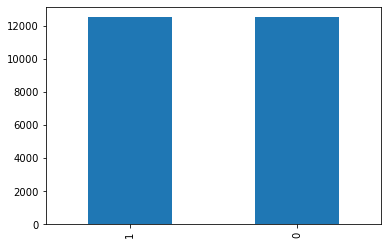

In [9]:
df['category'].value_counts().plot.bar()

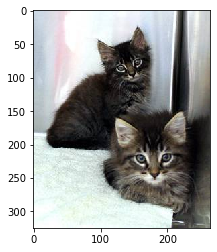

In [58]:
sample = random.choice(df['filename'])
image = load_img(sample)
plt.imshow(image)

# Obróbka zdjęć

In [133]:
from skimage.feature import hog
from skimage.color import rgb2gray

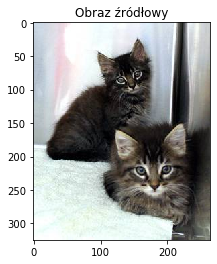

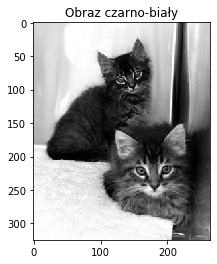

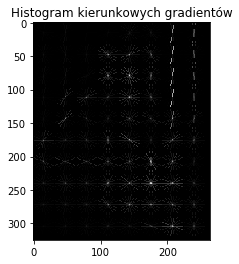

In [137]:
np_image = numpy.array(image)
plt.imshow(np_image)
plt.title('Obraz źródłowy')
plt.show()

np_gray = rgb2gray(np_image)
plt.imshow(np_gray, cmap='gray')
plt.title('Obraz czarno-biały')
plt.show()

hog_features, hog_image = hog(np_gray,
                              visualize=True,
                              block_norm='L2-Hys',
                              pixels_per_cell=(32, 32))

plt.imshow(hog_image, cmap='gray')
plt.title('Histogram kierunkowych gradientów')
plt.show()

In [219]:
import mahotas
import cv2

def ft_hu_moments(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    hu_moments = cv2.HuMoments(cv2.moments(image)).flatten()
    return hu_moments

def ft_haralick(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    haralick = mahotas.features.haralick(image).mean(axis=0)
    return haralick

def ft_histogram(image, mask=None):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    # chanels: [0,1,2], bo mamy przestrzeń HSV
    # mask: None
    # histSize: [8, 8, 8], bin count, po 8 dla każdego z kanałów
    # ranges : [0, 256, 0, 256, 0, 256], wszystko dla każdego z 3 kanałów
    hist  = cv2.calcHist([image], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
    cv2.normalize(hist, hist)
    return hist.flatten()

def ft_hog(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    hog_features = hog(image, block_norm='L2-Hys', pixels_per_cell=(32, 32))
    return hog_features

def preprocess_image(image_path, verbose=False):
    image = cv2.imread(image_path)
    image = cv2.resize(image, IMAGE_SIZE)
    histogram = ft_histogram(image)
    haralick = ft_haralick(image)
    hu = ft_hu_moments(image)
    hog = ft_hog(image)
    global_feature = numpy.hstack([histogram, haralick, hu]) #bez hog
    if verbose:
        print(f'Histagram shape: {histogram.shape}')
        print(f'harlick shape: {haralick.shape}')
        print(f'Hu shape: {hu.shape}')
#         print(f'Hog shape{hog.shape}')
    return global_feature
    

In [222]:
tmp = preprocess_image(sample, True)

print(f'Output Shape: {tmp.shape}\n')
# print(f'histogram: {tmp[:512][:20]}')
# print(f'haralick: {tmp[512:525]}')
# print(f'hu: {tmp[525:532]}')
# print(f'hog: {tmp[532:2557]}\n')

print(f'Max arg: {numpy.argmax(tmp)}, Min arg: {numpy.argmin(tmp)}')
print(f'Max: {numpy.amax(tmp)}, Min: {numpy.amin(tmp)}')

# ska
from sklearn.preprocessing import normalize

tmp = normalize(tmp)

print(f'Max arg: {numpy.argmax(tmp)}, Min arg: {numpy.argmin(tmp)}')
print(f'Max: {numpy.amax(tmp)}, Min: {numpy.amin(tmp)}')

Histagram shape: (512,)
harlick shape: (13,)
Hu shape: (7,)
Hog shape(2025,)
Output Shape: (532,)

Max arg: 518, Min arg: 523
Max: 31393.955337951924, Min: -0.3937995489665091


ValueError: Expected 2D array, got 1D array instead:
array=[ 5.99133000e-02  1.22777186e-01  1.01631314e-01  6.26999661e-02
  5.97493760e-02  5.07336967e-02  1.97525378e-02  9.76971984e-02
  5.77823184e-02  1.38185799e-01  1.33596003e-01  1.13269739e-01
  4.69635017e-02  1.79494023e-02  3.77019402e-03  0.00000000e+00
  5.08976169e-02  1.17121898e-01  6.78634942e-02  3.84395868e-02
  3.27842962e-03  4.09803702e-04  0.00000000e+00  0.00000000e+00
  2.48341039e-02  4.67995815e-02  1.36874430e-02  2.54078279e-03
  1.22941111e-03  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.77035201e-02  8.76979902e-03  4.09803702e-04  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  5.98313380e-03  5.73725149e-04  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  2.45882221e-03  3.27842950e-04  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  2.86862580e-03  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  3.52431182e-03  2.04901844e-02  1.72937158e-02  3.32760587e-02
  2.44242996e-02  3.04074343e-02  1.71297938e-02  5.42580076e-02
  7.04862364e-03  7.54038803e-03  3.60627240e-03  3.60627240e-03
  8.19607376e-05  1.63921475e-04  0.00000000e+00  0.00000000e+00
  6.55685901e-04  4.09803702e-04  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  3.27842950e-04  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.63921475e-04  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  8.19607376e-05  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  8.19607376e-05  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  2.78666499e-03  1.00811711e-02  9.01568122e-03  9.50744562e-03
  1.17203854e-02  4.13901731e-02  1.12204246e-01  8.16820681e-01
  7.04862364e-03  2.13097921e-03  1.22941111e-03  4.91764396e-04
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  3.36039020e-03  1.63921475e-04  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  6.55685901e-04  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  8.19607405e-04  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.06548960e-03  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  6.55685901e-04  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.06548960e-03  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.83592048e-02  3.27842943e-02  2.18015555e-02  2.33588107e-02
  3.90952714e-02  6.17983975e-02  2.26129681e-01  3.12926084e-01
  4.60619330e-02  2.22933199e-02  1.39333250e-03  3.27842950e-04
  2.45882198e-04  2.78666499e-03  5.10615408e-02  1.36874430e-02
  3.04893944e-02  2.95058661e-03  1.63921475e-04  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.51627362e-02  3.27842950e-04  1.63921475e-04  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.40972473e-02  1.63921475e-04  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  7.86823034e-03  8.19607376e-05  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  3.68823321e-03  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  7.62234861e-03  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  8.60587787e-03  1.27039142e-02  7.13058421e-03  2.70470441e-03
  2.54078279e-03  2.86862580e-03  5.98313380e-03  3.51611562e-02
  1.37694040e-02  1.63921481e-03  0.00000000e+00  1.63921475e-04
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.25399930e-02  4.91764396e-04  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  6.31097658e-03  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  7.29450583e-03  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  3.68823321e-03  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  2.70470441e-03  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  4.34391899e-03  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  3.15548852e-02  2.68831216e-02  8.52391683e-03  2.29490059e-03
  2.37686140e-03  4.34391899e-03  6.14705542e-03  1.04172096e-01
  4.19638976e-02  7.29450583e-03  1.22941111e-03  8.19607376e-05
  0.00000000e+00  0.00000000e+00  0.00000000e+00  9.99921001e-03
  1.72937158e-02  9.83528793e-04  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  4.01607621e-03  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  2.37686140e-03  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  2.04901840e-03  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  5.73725149e-04  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.31137180e-03  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  6.02837608e-04  2.44874539e+02  9.84521069e-01  7.90970747e+03
  2.53379107e-01  2.85598406e+02  3.13939553e+04  8.70257784e+00
  1.23890331e+01  3.18650997e-04  4.33266537e+00 -3.93799549e-01
  9.98742065e-01  1.35434347e-03  4.87441911e-08  4.50808693e-11
  2.93274330e-11  4.99190250e-22 -4.71291275e-15 -9.42311199e-22].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

# Załadownie danych do DF

In [185]:
from sklearn.preprocessing import MinMaxScaler

# Skalowanie danych
scaler = MinMaxScaler(feature_range=(0, 1))

g_f = []

for i in data_df['img']:
    data_img = preprocess_image(i) 
    data_scale = scaler.fit_transform(data_img)
    g_f.append(data_scale)

data_df = pd.DataFrame({
    'img': df['filename'],
    'data': g_f,
    'category': df['category']
})

ValueError: Expected 2D array, got 1D array instead:
array=[0.21608455 0.02513735 0.02039993 ... 0.04164853 0.02140158 0.01472173].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [193]:
numpy.array(data_df['data']).shape

(25000,)

In [186]:
data_df.head()

,img,data,category
0,../data/DogsCats/cats/cat.493.jpg,"[0.2160845547914505, 0.02513735182583332, 0.02...",1
1,../data/DogsCats/dogs/dog.9112.jpg,"[0.0035501210950315, 0.007019557524472475, 0.0...",0
2,../data/DogsCats/cats/cat.745.jpg,"[0.29563093185424805, 0.15299628674983978, 0.0...",1
3,../data/DogsCats/dogs/dog.11022.jpg,"[0.0008391551673412323, 0.0030209587421268225,...",0
4,../data/DogsCats/dogs/dog.11363.jpg,"[0.34515380859375, 0.08009958267211914, 0.0193...",0


In [166]:
data_df.shape

(25000, 3)

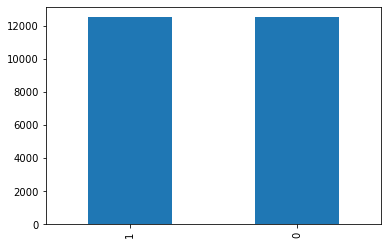

In [167]:
data_df['category'].value_counts().plot.bar()